In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from keras.utils import to_categorical

import pickle

# Functions

## Classes distribution

In [ ]:
def display_pie_chart(df, column_name, title=None, filename=None):
    """ Function to display the percentage ratio of column (with the name column_name) content 
    Args:
        1) df - the original dataframe that contains the required information
        2) column_name - the name of the df dataframe column whose percentage values are to be found
        3) title - the title of the graph
        4) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None, but plots graph
    """
    # Calculate the percentage of each activity in original_df
    activity_percentages_df = df[column_name].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

In [ ]:
def display_pie_charts(first_df, second_df, column, first_chart_title='First DataFrame', second_chart_title='Second DataFrame', filename=None):
    """Function for displaying the ratio of column content between two dataframes in the form of pie charts
    Args:
        1) first_df - the original dataframe that contains the required information
        2) second_df - a dataframe that contains the results of windowing 
        3) column - the name of the dataframe column whose percentage values are to be found
        4) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None; just builds a pie chart to display the ratio of column contents between two dataframes
    """
    # Calculate the percentage of each activity in first_df
    activity_percentages_first_df = first_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in second_df
    activity_percentages_second_df = second_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_first_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_second_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

## Model Training

In [ ]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()
    
    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()
    
    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

# Read and prepare train, validation and test datasets

## Read train_data and test_data

In [ ]:
train_data = pd.read_csv('data/40_Hz/model_data/train_data.csv')
train_data.head()

In [ ]:
train_data.info()

In [ ]:
test_data = pd.read_csv('data/40_Hz/model_data/test_data.csv')
test_data.head()

In [ ]:
test_data.info()

## Add 'activity_number' column to train_data and test_data

In [ ]:
activity_dict = {'Squat': 0, 'Leg land': 1, 'Walk': 2, 'Lateral squat slide': 3, 'Jogging': 4}
train_data['activity_number'] = train_data['activity'].apply(lambda x: activity_dict[x])
test_data['activity_number'] = test_data['activity'].apply(lambda x: activity_dict[x])
train_data.head()

#### Check the contents of the column 'activity_number'

In [ ]:
train_data[train_data['activity'] == 'Leg land'][:2]

In [ ]:
train_data[train_data['activity'] == 'Walk'][:2]

In [ ]:
train_data[train_data['activity'] == 'Lateral squat slide'][:2]

In [ ]:
train_data[train_data['activity'] == 'Jogging'][:2]

## Split train_data and test_data into required datasets

### Split train_data into X_train, y_train, X_valid, y_valid  

#### View the distribution of classes before dividing the train_data dataset

In [ ]:
display_pie_chart(df=train_data, column_name='activity', title='Class label distribution')

In [ ]:
display_pie_chart(df=train_data, column_name='activity_number', title='Class label distribution')

#### Perform spliting

In [ ]:
X_train = pd.DataFrame()
y_train = []

X_valid = pd.DataFrame()
y_valid = []

counter = 0

for activity in train_data['activity'].unique():
    activity_data = train_data[train_data['activity'] == activity].copy()
    activity_data.reset_index(inplace=True)
    activity_data.drop('index', axis=1, inplace=True)
    split_index = int(0.8 * len(activity_data))
    if counter != 0:
        X_train = pd.concat([X_train, activity_data[activity_data.columns[:-2]][:split_index]])
    else:
        X_train = activity_data[activity_data.columns[:-2]][:split_index]
        
    y_train.extend(list(activity_data['activity_number'].values[:split_index]))
    
    
    if counter != 0:
        X_valid = pd.concat([X_valid, activity_data[activity_data.columns[:-2]][split_index:]])
    else:
        X_valid = activity_data[activity_data.columns[:-2]][split_index:]
        
    y_valid.extend(list(activity_data['activity_number'].values[split_index:]))
    
    counter += 1
    
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

#### View the distribution of classes after dividing the train_data dataset

In [ ]:
train_df = X_train.copy()
train_df['activity_number'] = y_train

valid_df = X_valid.copy()
valid_df['activity_number'] = y_valid

display_pie_charts(first_df=train_df, second_df=valid_df, column='activity_number', 
                   first_chart_title='Train_df class label distribution',
                   second_chart_title='Validation_df class label distribution')

### Split test_data into X_test, y_test

In [ ]:
display_pie_chart(df=test_data, column_name='activity_number', title='Class label distribution')

In [ ]:
X_test = test_data[test_data.columns[:-2]]
y_test = test_data['activity_number'].values

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

# Model training

### View the sizes of the training, validation and test datasets

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Convert Label Encoded target data to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_valid_encoded = to_categorical(y_valid)
y_test_encoded = to_categorical(y_test)

print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

### Scale X_train, X_valid, X_test datasets

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Train the NN model

In [ ]:
best_model = None
best_model_accuracy = None
best_model_history = None

In [ ]:
experiments_number = 5

accuracy_list = []

for i in range(experiments_number):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(120, activation='relu', input_shape=(len(X_train.columns), )))
    model.add(tf.keras.layers.Dense(60, activation='relu'))
    model.add(tf.keras.layers.Dense(30, activation='relu'))
    model.add(tf.keras.layers.Dense(15, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train_encoded, epochs=5, verbose=0, batch_size=10, validation_data=(X_valid_scaled, y_valid_encoded))
          
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test_scaled, y_test_encoded)
        
    accuracy_list.append(accuracy)
    print(f'Accuracy: {accuracy*100:.3f}')
    
    if best_model == None:
        best_model = model
        best_model_accuracy = accuracy
        best_model_history = history
        continue
        
    if accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = model
        best_model_history = history
        print(f'best_model_accuracy: {accuracy*100:.3f}')
        
print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')

In [ ]:
best_model_accuracy

In [ ]:
plt.rcdefaults()
plot_graphs(history=best_model_history, strings=['accuracy', 'loss'], filename='graphs/best_epochs')

In [ ]:
# Get predicted labels
y_pred_encoded = best_model.predict(X_test_scaled)
y_pred_labels = y_pred_encoded.argmax(axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Define class names
class_names = ['Squat', 'Leg land', 'Walk', 'Lateral squat slide', 'Jogging']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.savefig('graphs/best_confusion_matrix.png')
# Show the heatmap
plt.show()

In [ ]:
# Calculate and print classification report
class_report = classification_report(y_test, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(class_report)

In [ ]:
for activity in test_data['activity'].unique():
    print(f"{activity}: {len(test_data[test_data['activity'] == activity])}")

### Save the best_model and best_model_history

In [ ]:
best_model.save('models/best_model.h5')

In [ ]:
with open('models/histories/best_model_history.pkl', 'wb') as f:
    pickle.dump(best_model_history.history, f)

# Feature Selection

## Load the best model from the saved files

In [ ]:
loaded_model = tf.keras.models.load_model('models/best_model.h5')

## Permutation Feature Importance

In [65]:
# Define a scoring function that uses model predictions
def custom_score(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert to class predictions
    y_true_classes = y.argmax(axis=1)       # Convert one-hot encoded to class labels
    return accuracy_score(y_true_classes, y_pred_classes)

In [ ]:
# Calculate permutation feature importance
perm_importance = permutation_importance(
    loaded_model, X_test_scaled, y_test_encoded,
    scoring=custom_score, n_repeats=10, random_state=42
)

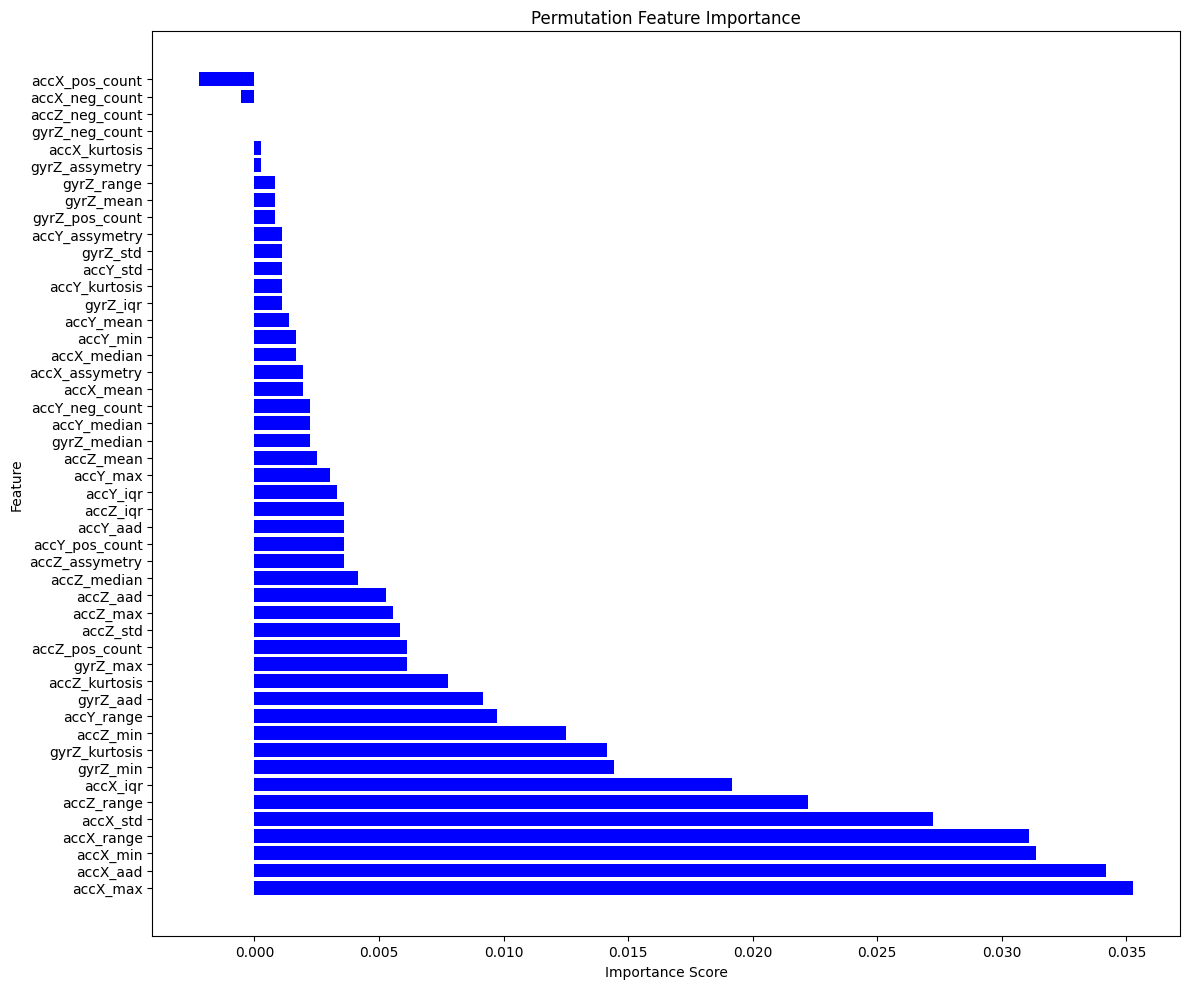

In [67]:
# Get feature names and their importance scores
feature_names = X_test.columns
importance_scores = perm_importance.importances_mean

# Sort features by importance scores
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Create a bar plot
plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_feature_names)), sorted_importance_scores, align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.tight_layout()

plt.savefig('graphs/permutation_feature_importance.png')
plt.show()

### Remove some features and view model training results

In [103]:
pfi_columns = ['accX_max', 'accX_aad', 'accX_min', 'accX_range', 'accX_std', 'accZ_range', 'accX_iqr', 'gyrZ_min', 'accX_neg_count', 'accY_pos_count'
              ]
print(f"len(pfi_columns) = {len(pfi_columns)}")
X_train_pfi = X_train[pfi_columns]
X_valid_pfi = X_valid[pfi_columns]
X_test_pfi = X_test[pfi_columns]
X_train_pfi.head()

len(pfi_columns) = 10


,accX_max,accX_aad,accX_min,accX_range,accX_std,accZ_range,accX_iqr,gyrZ_min,accX_neg_count,accY_pos_count
0,0.624975,0.164112,-0.029025,0.654000,0.191702,8.576401,0.293719,-0.370494,3,30
1,0.624975,0.181807,-0.168450,0.793425,0.211233,8.576401,0.353306,-0.444056,7,48
2,0.682500,0.187870,-0.168450,0.850950,0.216026,8.796450,0.359869,-0.509575,6,54
3,0.907500,0.219851,-0.493950,1.401450,0.288013,9.314551,0.294206,-0.509575,13,62
4,0.907500,0.218381,-0.516450,1.423950,0.278074,9.314551,0.389550,-0.327181,30,62


In [104]:
print(f"len(X_train) = {len(X_train)}")
print(f"len(X_train_pfi) = {len(X_train_pfi)}")

print(f"\nlen(X_valid) = {len(X_valid)}")
print(f"len(X_valid_pfi) = {len(X_valid_pfi)}")

print(f"\nlen(X_test) = {len(X_test)}")
print(f"len(X_test_pfi) = {len(X_test_pfi)}")

len(X_train) = 1439
len(X_train_pfi) = 1439

len(X_valid) = 360
len(X_valid_pfi) = 360

len(X_test) = 360
len(X_test_pfi) = 360


In [105]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_pfi_scaled = scaler.fit_transform(X_train_pfi)

# Transform the validation and test data using the same scaler
X_valid_pfi_scaled = scaler.transform(X_valid_pfi)
X_test_pfi_scaled = scaler.transform(X_test_pfi)

In [81]:
best_model = None
best_model_accuracy = None
best_model_history = None

In [108]:
experiments_number = 5

accuracy_list = []

print(f"len(X_train_pfi.columns) = {len(X_train_pfi.columns)}")
for i in range(experiments_number):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(60, activation='relu', input_shape=(len(X_train_pfi.columns), )))
    model.add(tf.keras.layers.Dense(30, activation='relu'))
    model.add(tf.keras.layers.Dense(15, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train_pfi_scaled, y_train_encoded, epochs=5, verbose=0, batch_size=10, validation_data=(X_valid_pfi_scaled, y_valid_encoded))
          
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test_pfi_scaled, y_test_encoded)
        
    accuracy_list.append(accuracy)
    print(f'Accuracy: {accuracy*100:.3f}')
    
    if best_model == None:
        best_model = model
        best_model_accuracy = accuracy
        best_model_history = history
        continue
        
    if accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = model
        best_model_history = history
        print(f'best_model_accuracy: {accuracy*100:.3f}')
        
print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')

len(X_train_pfi.columns) = 10
12/12 [==============================] - 0s 1ms/step - loss: 0.4626 - accuracy: 0.8444
Accuracy: 84.444
12/12 [==============================] - 0s 2ms/step - loss: 0.5536 - accuracy: 0.8167
Accuracy: 81.667
12/12 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.8306
Accuracy: 83.056
12/12 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.8556
Accuracy: 85.556
12/12 [==============================] - 0s 1ms/step - loss: 0.4147 - accuracy: 0.8500
Accuracy: 85.000

Average accuracy = 83.944
